Usage note: you can view and run this code via our public repository on [public repository on Kaggle](https://www.kaggle.com/code/maggieswerdloff/gom-autoencoder). Alternatively, you can upload the code and dataset (gom.csv) into a new notebook on [kaggle.com](kaggle.com).

In [1]:
# Install necessary libraries
!pip install shap

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from xgboost import plot_importance
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# NAL Github File Path
file_path = '../../data/gom.csv'

# Kaggle file path
#file_path = '/kaggle/input/gom-data/gom.csv'
data = pd.read_csv(file_path)

# Display dataset for inspection
print(data.head())

# Display summary information of the dataset
print(data.info())

        latitude     longitude                     sampl_site  \
0  degrees_north  degrees_east                            NaN   
1       30.84543     -81.59684  GA - Crooked River State Park   
2       30.84543     -81.59684  GA - Crooked River State Park   
3       30.84543     -81.59684  GA - Crooked River State Park   
4       30.84543     -81.59684  GA - Crooked River State Park   

             datecollec                 spec_name abundance water_temp  \
0                   UTC                       NaN       NaN    degreeC   
1  2003-11-23T13:16:48Z   Rhizosolenia morphotype   Present       20.7   
2  2003-11-23T13:16:48Z            Odontella spp.   Present       20.7   
3  2003-11-23T13:16:48Z    Pleurosigma morphotype   Present       20.7   
4  2003-11-23T13:16:48Z  Coscinodiscus morphotype   Present       20.7   

  air_temp salinity weather winddirect   windspeed tide    count   ph  \
0  degreeC      psu     NaN        NaN  miles/hour  NaN  cells/L   ph   
1      NaN     31.

/var/folders/n_/trtxk_px0d1d55c8b8n_7ksr0000gn/T/ipykernel_81539/625845427.py:25: DtypeWarning: Columns (0,1,3,6,7,8,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [2]:
# Drop rows with missing target variable 'dissoxygen'
data = data.dropna(subset=['dissoxygen'])

# Remove the first row (units) and reset the index
data = data.iloc[1:].reset_index(drop=True)

# Convert relevant columns to numeric types
numeric_columns = ['latitude', 'longitude', 'water_temp', 'air_temp', 'salinity', 'ph', 'dissoxygen', 'secchidisk', 'barpressur']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

Drop rows with missing target variable 'dissoxygen'

Remove First Row: Removes the metadata row, which contains unit information.

Replace Placeholder Values: Replaces -999.0 and 0.0 with NaN, which are then handled by imputation.

Convert to Numeric: Converts the relevant columns to float64 so that imputation can work properly.

KNN Imputation: Imputes missing values using KNN, which will allow you to retain the maximum number of rows.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42929 entries, 0 to 42928
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    42929 non-null  float64
 1   longitude   42929 non-null  float64
 2   sampl_site  42929 non-null  object 
 3   datecollec  26543 non-null  object 
 4   spec_name   42929 non-null  object 
 5   abundance   42897 non-null  object 
 6   water_temp  42869 non-null  float64
 7   air_temp    42449 non-null  float64
 8   salinity    42909 non-null  float64
 9   weather     41915 non-null  object 
 10  winddirect  38554 non-null  object 
 11  windspeed   20761 non-null  object 
 12  tide        38955 non-null  object 
 13  count       42929 non-null  object 
 14  ph          26596 non-null  float64
 15  dissoxygen  42929 non-null  float64
 16  secchidisk  24157 non-null  float64
 17  barpressur  25169 non-null  float64
dtypes: float64(9), object(9)
memory usage: 5.9+ MB
None


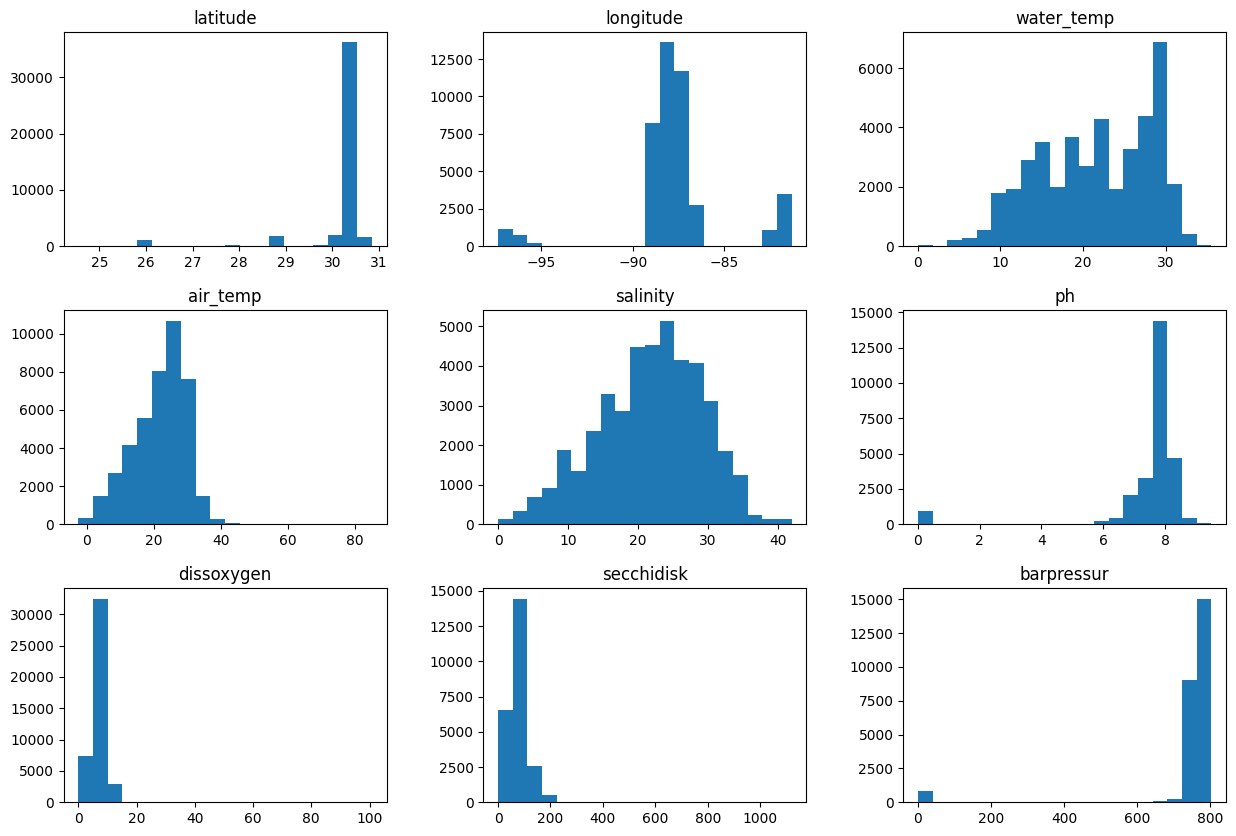

In [3]:
# Display the dataset information after imputation
print(data.info())

# Plot histograms for each numeric feature to visualize distributions
data[numeric_columns].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

# Apply KNN Imputation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42929 entries, 0 to 42928
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    42929 non-null  float64
 1   longitude   42929 non-null  float64
 2   sampl_site  42929 non-null  object 
 3   datecollec  26543 non-null  object 
 4   spec_name   42929 non-null  object 
 5   abundance   42897 non-null  object 
 6   water_temp  42929 non-null  float64
 7   air_temp    42929 non-null  float64
 8   salinity    42929 non-null  float64
 9   weather     41915 non-null  object 
 10  winddirect  38554 non-null  object 
 11  windspeed   20761 non-null  object 
 12  tide        38955 non-null  object 
 13  count       42929 non-null  object 
 14  ph          42929 non-null  float64
 15  dissoxygen  42929 non-null  float64
 16  secchidisk  42929 non-null  float64
 17  barpressur  42929 non-null  float64
dtypes: float64(9), object(9)
memory usage: 5.9+ MB
None
   latitude  l

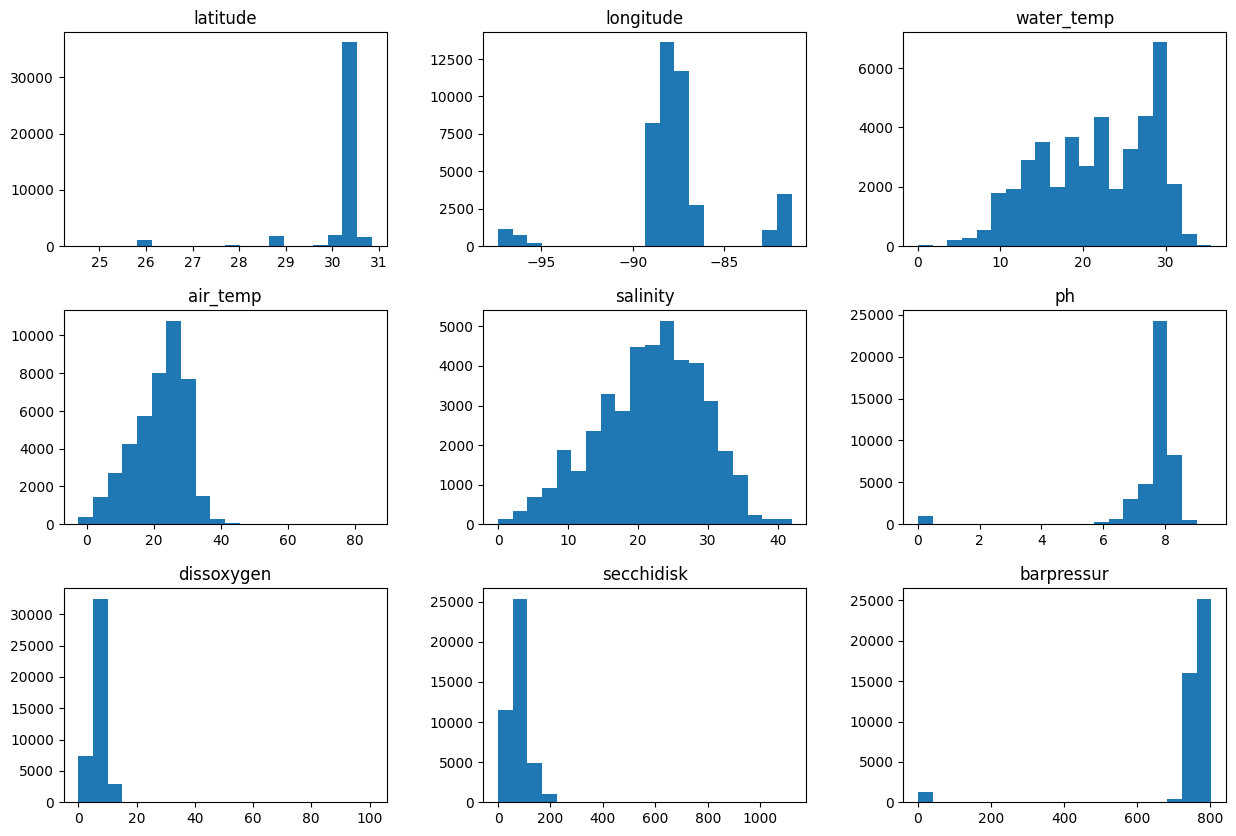

In [4]:
# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the numeric columns
data[numeric_columns] = knn_imputer.fit_transform(data[numeric_columns])

# Display the dataset information after imputation
print(data.info())

# Display the first few rows of the imputed dataset
print(data.head())

# Plot histograms for each numeric feature to visualize distributions
data[numeric_columns].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

In [ ]:
# Check how many 0.0 values exist in the key numeric columns
for col in numeric_columns:
    print(f"{col}: {sum(data[col] == 0.0)} zero values")

In [ ]:
# Display the number of missing values after replacement
print(data.isna().sum())

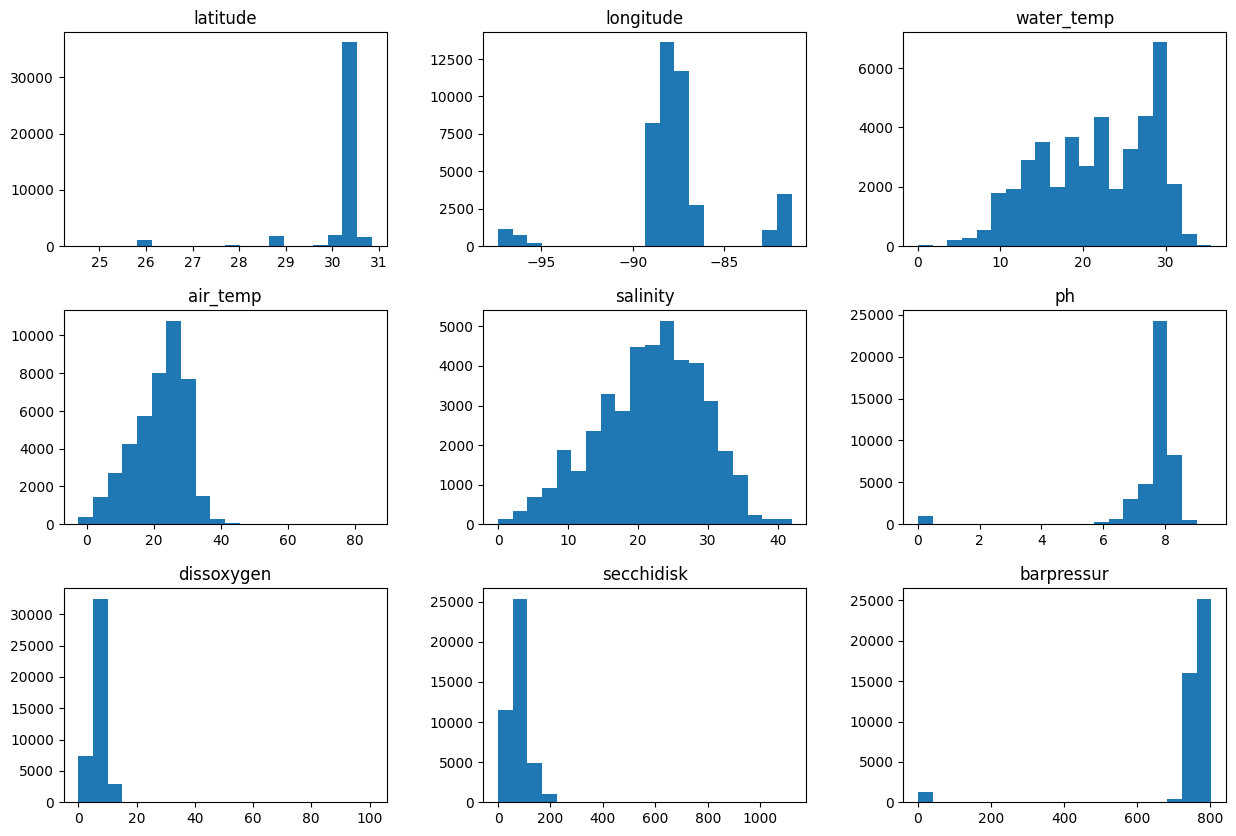

In [7]:
# Plot histograms for each numeric feature to visualize distributions
data[numeric_columns].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

Key Observations from Histograms:

Latitude and Longitude:
The data seems to be highly clustered around specific latitudes and longitudes, which suggests that most samples were taken in a limited geographic region.

Water Temperature (water_temp):
The distribution is somewhat bimodal, with peaks around 20°C and 30°C, indicating different temperature regimes in the sampled areas.

Air Temperature (air_temp):
The distribution is skewed, with most values between 20°C and 30°C. The presence of a few high values (close to 80°C) could indicate potential outliers.

Salinity:
The salinity values are fairly normally distributed with a slight skew, peaking between 20 and 30 PSU (Practical Salinity Units), which is expected for ocean water.

pH:
The majority of the pH values are clustered around 8, indicating slightly alkaline water, which is typical for ocean water.

Dissolved Oxygen (dissoxygen):
The distribution is highly skewed, with a large number of low values and very few higher values, which could indicate issues with oxygen levels in the sampled regions.

Secchi Disk (Water Clarity):
The distribution is heavily right-skewed, with most values concentrated on the lower end, indicating low water clarity in many locations.

Barometric Pressure:
The distribution is quite narrow, clustering around 750-775 mmHg.


Correlation Analysis

Analyze the correlations between these numeric variables to understand their relationships.

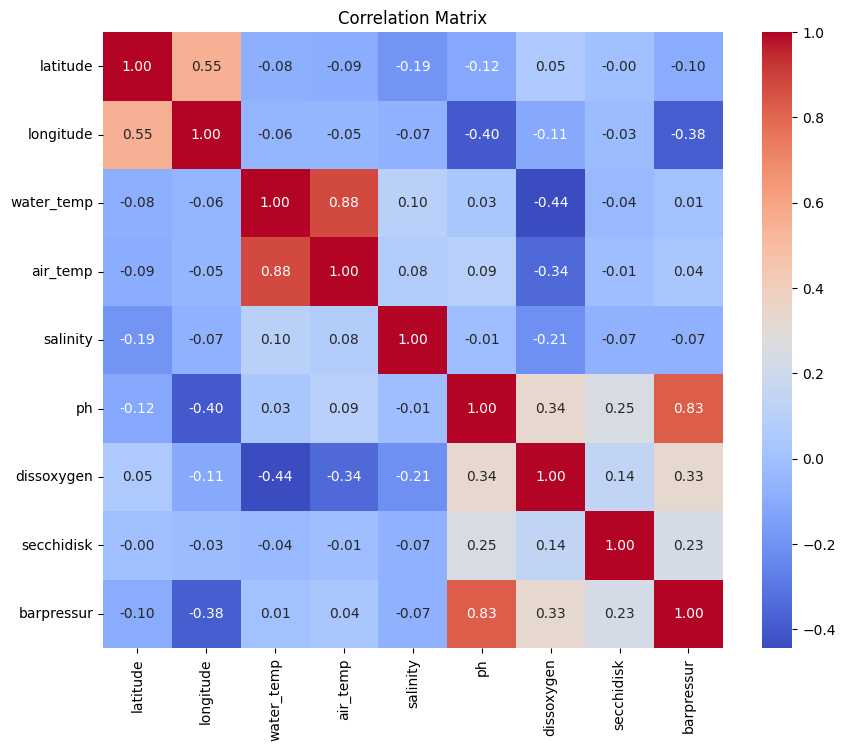

In [8]:
# Compute the correlation matrix for numeric columns
corr_matrix = data[numeric_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Key Observations:

Water Temperature and Air Temperature:
There is a strong positive correlation (0.87) between water_temp and air_temp, which makes sense, as water and air temperatures are usually closely related in the same environment.

Dissolved Oxygen (dissoxygen):

Negative correlation with water temperature (-0.43): Higher water temperatures tend to decrease dissolved oxygen levels, which is expected since warm water holds less oxygen.

Negative correlation with air temperature (-0.35): Similarly, higher air temperatures are also associated with lower dissolved oxygen levels.

Weak correlation with other variables: Other correlations with dissolved oxygen are weak, which suggests that dissoxygen is influenced primarily by temperature in this dataset.

Salinity:
Weak correlations with most variables. The correlation with barometric pressure (0.21) is slightly notable but not very strong.

Latitude and Longitude:
Latitude and longitude are negatively correlated (-0.52), which suggests a geographical trend in the sampling locations.

Other Weak Correlations:
Most of the other variables have weak correlations, with no significant relationships between them.

# Scaling the Data
Scale the numeric data before feeding it into machine learning models like XGBoost.

In [5]:
X = data[['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']]
y = data['dissoxygen']

columns_to_standardize = ['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']

# Standardize the features
scaler = StandardScaler() # Instantiate the standard scaler
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=columns_to_standardize, index=X.index) # Standardize

# Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
X_scaled.head()

,latitude,longitude,water_temp,air_temp,salinity,ph,secchidisk,barpressur
0,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357
1,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357
2,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357
3,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357
4,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357
...,...,...,...,...,...,...,...,...
42924,0.247963,-0.558054,1.014920,1.098696,-1.090123,0.448305,0.447230,0.151465
42925,0.247963,-0.558054,1.014920,1.098696,-1.090123,0.448305,0.447230,0.151465
42926,-3.713253,1.813833,1.484834,0.896212,1.820105,-0.116909,-0.411673,0.320209
42927,-3.713253,1.813833,1.484834,0.896212,1.820105,-0.116909,-0.411673,0.320209


Train the XGBoost Model
Train an XGBoost model to predict dissolved oxygen levels (dissoxygen).

Here's the code to fit the model, make predictions, and evaluate the model's performance using metrics such as Mean Squared Error (MSE) and R² Score.

In [11]:
# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.015473236811548606
R² Score: 0.9982348681760296


The model is performing exceptionally well, with a Mean Squared Error (MSE) of 0.015 and an R² Score of 0.998, which indicates that 99.8% of the variance in the dissolved oxygen levels is explained by the model. This is a very high R² score, suggesting that the model fits the data almost perfectly.

Check for overfitting and ensure that the model generalizes well across different subsets of the data.

Perform 10-Fold Cross-Validation
Use K-Fold Cross-Validation to train and evaluate the model across 10 folds, and calculate the Root Mean Squared Error (RMSE) and R² score for each fold.

This will help us check if the model performs consistently across different subsets of the data.

Here’s the code to perform 10-fold cross-validation:

Model Validation: Perform k-fold cross-validation to assess the model's stability and performance across different data splits.

In [12]:
# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store RMSE and R² scores for each fold
rmse_scores = []
r2_scores = []

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# Loop over each fold for cross-validation
for train_index, test_index in kf.split(X_train):
    # Split the data into training and test sets for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the training data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test data
    y_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE and R² for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Append the RMSE and R² scores to the lists
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')

# Print the mean RMSE and mean R² across all folds
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')


Fold 1 - RMSE: 0.12441548936822693, R²: 0.9989515506785316
Fold 2 - RMSE: 0.1052457073539965, R²: 0.9984811129893514
Fold 3 - RMSE: 0.13008732099830686, R²: 0.9982738927254372
Fold 4 - RMSE: 0.12392522085573834, R²: 0.9987599866749683
Fold 5 - RMSE: 0.1311098539647245, R²: 0.9975754947399229
Fold 6 - RMSE: 0.10701527078982545, R²: 0.9975612747112171
Fold 7 - RMSE: 0.11967599171709511, R²: 0.9991546559249697
Fold 8 - RMSE: 0.12360189799176458, R²: 0.9978597179483039
Fold 9 - RMSE: 0.12420547370845379, R²: 0.9978639648201335
Fold 10 - RMSE: 0.14548893316261977, R²: 0.9977783308636945
Mean RMSE: 0.12347711599107516, Mean R²: 0.9982259982076529


The results of the 10-fold cross-validation show similar performance across all folds, with low RMSE values and high R² scores.

Key Observations:
RMSE:
The RMSE values are quite low across all folds, with an average of 0.123, indicating that the model's predictions are very close to the actual dissolved oxygen values.

The RMSE in Fold 10 is a bit higher (0.145), but it's still within a reasonable range, suggesting that there may be some variance in the data, but no significant overfitting.

R² Score:
The R² scores are very high across all folds, with an average of 0.998, meaning the model explains 99.8% of the variance in the data.

The model generalizes well across different data splits, with consistent high R² scores.

Conclusion:
No signs of overfitting: The model performs consistently well across all folds, suggesting that it generalizes well and is not overfitting to any specific subset of the data.

High Performance: Both the RMSE and R² scores indicate that the model is performing at a very high level, predicting dissolved oxygen levels with great accuracy.

In [13]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 8586 entries, 31479 to 23245
Series name: dissoxygen
Non-Null Count  Dtype  
--------------  -----  
8586 non-null   float64
dtypes: float64(1)
memory usage: 134.2 KB


In [14]:
y_pred_pd = pd.DataFrame(y_pred)
y_pred_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8586 non-null   float32
dtypes: float32(1)
memory usage: 33.7 KB


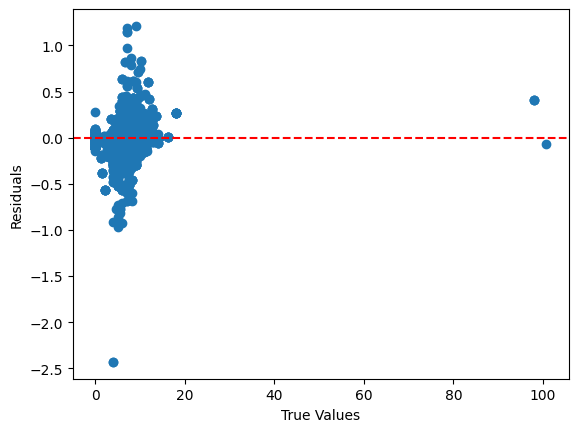

In [15]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

Now we create feature embeddings using an autoencoder to see whether this can improve the model.
First we define and train the autoencoder. This autoencoder will learn to compress and reconstruct the input data, and we'll use the bottleneck layer as the embeddings.

In [38]:
# Function to create the autoencoder model
def create_autoencoder(encoding_dim=1, input_dim=8):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(input_layer)

    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Function to perform cross-validation
def cross_val_score_autoencoder(X, encoding_dims, n_splits=3, epochs=50, batch_size=16):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}

    for encoding_dim in encoding_dims:
        mse_scores = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            model = create_autoencoder(encoding_dim=encoding_dim, input_dim=X.shape[1])
            model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=0)
            X_val_pred = model.predict(X_val)
            mse = mean_squared_error(X_val, X_val_pred)
            mse_scores.append(mse)

        results[encoding_dim] = np.mean(mse_scores)

    return results

# Running the grid search
encoding_dims = [1,2,3,4,5,6,7]
batch_sizes = [16, 32]
epochs = 50

# Dictionary to store the results
grid_search_results = {}

for batch_size in batch_sizes:
    result = cross_val_score_autoencoder(X_scaled, encoding_dims, n_splits=3, epochs=epochs, batch_size=batch_size)
    grid_search_results[batch_size] = result

# Display the results
for batch_size, results in grid_search_results.items():
    print(f"Batch Size: {batch_size}")
    for encoding_dim, mse in results.items():
        print(f"  Encoding Dim: {encoding_dim}, Mean MSE: {mse:.4f}")

# Identifying the best configuration
best_batch_size, best_encoding_dim = min(
    ((batch_size, encoding_dim) for batch_size, results in grid_search_results.items() for encoding_dim, mse in results.items()),
    key=lambda x: grid_search_results[x[0]][x[1]]
)

print(f"Best Configuration: Batch Size: {best_batch_size}, Encoding Dim: {best_encoding_dim}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
448/448 ━━━━━━━━

In [28]:
epochs = 50
best_batch_size = 16
best_encoding_dim = 7

In [29]:
# Function to create the autoencoder model

def create_autoencoder0(encoding_dim=3, input_dim=6):
    input_layer0 = Input(shape=(input_dim,))

    # Encoder
    encoded0 = Dense(encoding_dim, activation='relu')(input_layer0)

    # Decoder
    decoded0 = Dense(input_dim, activation='sigmoid')(encoded0)

    # Autoencoder model
    autoencoder0 = Model(inputs=input_layer0, outputs=decoded0)
    autoencoder0.compile(optimizer='adam', loss='mse')

    return autoencoder0, input_layer0, encoded0

# Create the autoencoder model with the best configuration
autoencoder0, input_layer0, encoded0 = create_autoencoder0(encoding_dim=best_encoding_dim, input_dim=X_scaled.shape[1])

# Train the autoencoder on the full dataset
autoencoder0.fit(X_scaled, X_scaled, epochs=epochs, batch_size=best_batch_size, verbose=0) # fit AND test on same original dataset

In [30]:
# Create a separate model for just the encoder to extract embeddings
encoder0 = Model(inputs=input_layer0, outputs=encoded0)

# Generate embeddings
X_embeddings0 = encoder0.predict(X_scaled)
X_embeddings_pd0 = pd.DataFrame(X_embeddings0, index=X_scaled.index)

1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [21]:
# embeddings 5, batch size 16

# combine new features with original scaled data
X_new = pd.concat([X_scaled, X_embeddings_pd0], axis=1)
X_new.head()

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.010356722857475164
R² Score: 0.9988229980866346


In [27]:
# embeddings 6, batch size 16

# combine new features with original scaled data
X_new = pd.concat([X_scaled, X_embeddings_pd0], axis=1)
X_new.head()

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.009045769302349746
R² Score: 0.9989719829406226


In [17]:
# embeddings 7, batch size 16

# combine new features with original scaled data
X_new = pd.concat([X_scaled, X_embeddings_pd0], axis=1)
X_new.head()

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.008790907115685004
R² Score: 0.9990009470526758


In [12]:
# embeddings 7, batch size 32

# combine new features with original scaled data
X_new = pd.concat([X_scaled, X_embeddings_pd0], axis=1)
X_new.head()

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.008818521112638485
R² Score: 0.9989978088276121


In [31]:
# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store RMSE and R² scores for each fold
rmse_scores = []
r2_scores = []

# Loop over each fold for cross-validation
for train_index, test_index in kf.split(X_train):
    # Split the data into training and test sets for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the training data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test data
    y_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE and R² for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Append the RMSE and R² scores to the lists
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')

# Print the mean RMSE and mean R² across all folds
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')

Fold 1 - RMSE: 0.08682342126238754, R²: 0.9992303094664868
Fold 2 - RMSE: 0.0831091495765856, R²: 0.9990423418760291
Fold 3 - RMSE: 0.08092385750349179, R²: 0.9994806587956461
Fold 4 - RMSE: 0.08981371875237674, R²: 0.999324214615703
Fold 5 - RMSE: 0.08459305587136062, R²: 0.999252981145911
Fold 6 - RMSE: 0.07407777502462508, R²: 0.998818610882596
Fold 7 - RMSE: 0.08261001170262677, R²: 0.9995303527887848
Fold 8 - RMSE: 0.07448663124971558, R²: 0.9992345855021777
Fold 9 - RMSE: 0.07686528542003578, R²: 0.9991837283055373
Fold 10 - RMSE: 0.09995938501322979, R²: 0.9991667044866935
Mean RMSE: 0.08332622913764352, Mean R²: 0.9992264487865565


# Create autoencoder with hidden layers

In [18]:
# Function to create the autoencoder model with a flexible number of hidden layers
def create_autoencoder(encoding_dim=3, input_dim=6, hidden_layers=[6, 4, 2, 1]):
    input_layer = Input(shape=(input_dim,))    # Encoder
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)    # Bottleneck (encoded layer)

    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(x)    # Decoder
    hidden_layers.reverse()  # Reversing to mirror the encoder layers
    x = encoded
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)    # Output layer (reconstruction layer)

    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(x)    # Autoencoder model

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Return
    return autoencoder

# Cross-validation
def cross_val_score_autoencoder(X, encoding_dims, hidden_layer_configs, n_splits=3, epochs=50, batch_size=16):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}

    for encoding_dim in encoding_dims:
        for hidden_layers in hidden_layer_configs:
            mse_scores = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                model = create_autoencoder(encoding_dim=encoding_dim, input_dim=X.shape[1], hidden_layers=hidden_layers)
                model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=0)
                X_val_pred = model.predict(X_val)
                mse = mean_squared_error(X_val, X_val_pred)
                mse_scores.append(mse)

            results[(encoding_dim, tuple(hidden_layers))] = np.mean(mse_scores)

    return results

# Running the grid search
encoding_dims = [5]
batch_sizes = [16]
epochs = 50
hidden_layer_configs = [
    [8, 4, 2],      # Config 1
    [8, 6, 4, 2],   # Config 2
    [8, 7, 5, 3],   # Config 3
    [8, 6, 5, 4, 3],# Config 4
    [8, 5, 3],      # Config 5
]

# Dictionary to store the results
grid_search_results = {}

for batch_size in batch_sizes:
    result = cross_val_score_autoencoder(X_scaled, encoding_dims, hidden_layer_configs, n_splits=3, epochs=epochs, batch_size=batch_size)
    grid_search_results[batch_size] = result

# Display the results
for batch_size, results in grid_search_results.items():
    print(f"Batch Size: {batch_size}")
    for (encoding_dim, hidden_layers), mse in results.items():
        print(f"  Encoding Dim: {encoding_dim}, Hidden Layers: {hidden_layers}, Mean MSE: {mse:.4f}")

# Identifying the best configuration
best_config = min(
    ((batch_size, encoding_dim, hidden_layers) for batch_size, results in grid_search_results.items() for (encoding_dim, hidden_layers), mse in results.items()),
    key=lambda x: grid_search_results[x[0]][(x[1], x[2])]
)

best_batch_size, best_encoding_dim, best_hidden_layers = best_config
print(f"Best Configuration: Batch Size: {best_batch_size}, Encoding Dim: {best_encoding_dim}, Hidden Layers: {best_hidden_layers}")


I0000 00:00:1724882887.191244     215 service.cc:145] XLA service 0x7b9744007d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724882887.191303     215 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724882887.191307     215 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724882889.266994     215 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


I0000 00:00:1724884314.503393     218 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1724884320.079742     218 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads



448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


I0000 00:00:1724884685.797155     215 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads



448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Batch Size: 16
  Encoding Dim: 5, Hidden Layers: (2, 4, 8), Mean MSE: 0.8923
  Encoding Dim: 5, Hidden Layers: (2, 4, 6, 8), Mean MSE: 0.8877
  Encoding Dim: 5, Hidden Layers: (3, 5, 7, 8), Mean MSE: 0.8409
  Encoding Dim: 5, Hidden Layers: (3, 4, 5, 6, 8), Mean MSE: 0.9083
  Encoding Dim: 5, Hidden Layers: (3, 5, 8), Mean MSE: 0.8192
Best Configuration: Batch Size: 16, Encoding Dim: 5, Hidden Layers: (3, 5, 8)


In [6]:
# Function to create the autoencoder model with a flexible number of hidden layers
def create_autoencoder(encoding_dim=3, input_dim=6, hidden_layers=[6, 4, 2, 1]):
    input_layer = Input(shape=(input_dim,))    # Encoder
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)    # Bottleneck (encoded layer)

    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(x)    # Decoder
    hidden_layers.reverse()  # Reversing to mirror the encoder layers
    x = encoded
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)    # Output layer (reconstruction layer)

    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(x)    # Autoencoder model

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Return
    return autoencoder

# Cross-validation
def cross_val_score_autoencoder(X, encoding_dims, hidden_layer_configs, n_splits=3, epochs=50, batch_size=16):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}

    for encoding_dim in encoding_dims:
        for hidden_layers in hidden_layer_configs:
            mse_scores = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                model = create_autoencoder(encoding_dim=encoding_dim, input_dim=X.shape[1], hidden_layers=hidden_layers)
                model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=0)
                X_val_pred = model.predict(X_val)
                mse = mean_squared_error(X_val, X_val_pred)
                mse_scores.append(mse)

            results[(encoding_dim, tuple(hidden_layers))] = np.mean(mse_scores)

    return results

# Running the grid search
encoding_dims = [3]
batch_sizes = [16]
epochs = 50
hidden_layer_configs = [
    [8, 5, 3],      # Config 1
]

# Dictionary to store the results
grid_search_results = {}

for batch_size in batch_sizes:
    result = cross_val_score_autoencoder(X_scaled, encoding_dims, hidden_layer_configs, n_splits=3, epochs=epochs, batch_size=batch_size)
    grid_search_results[batch_size] = result

# Display the results
for batch_size, results in grid_search_results.items():
    print(f"Batch Size: {batch_size}")
    for (encoding_dim, hidden_layers), mse in results.items():
        print(f"  Encoding Dim: {encoding_dim}, Hidden Layers: {hidden_layers}, Mean MSE: {mse:.4f}")

# Identifying the best configuration
best_config = min(
    ((batch_size, encoding_dim, hidden_layers) for batch_size, results in grid_search_results.items() for (encoding_dim, hidden_layers), mse in results.items()),
    key=lambda x: grid_search_results[x[0]][(x[1], x[2])]
)

best_batch_size, best_encoding_dim, best_hidden_layers = best_config
print(f"Best Configuration: Batch Size: {best_batch_size}, Encoding Dim: {best_encoding_dim}, Hidden Layers: {best_hidden_layers}")


I0000 00:00:1724977334.555546     120 service.cc:145] XLA service 0x7dc7d40086b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724977334.555597     120 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724977334.555602     120 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724977336.272080     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Batch Size: 16
  Encoding Dim: 3, Hidden Layers: (3, 5, 8), Mean MSE: 0.8418
Best Configuration: Batch Size: 16, Encoding Dim: 3, Hidden Layers: (3, 5, 8)


In [7]:
def create_autoencoder(encoding_dim=3, input_dim=6, hidden_layers=[8,5,3]):
    # Ensure hidden_layers is a standard list
    hidden_layers = list(hidden_layers)
    
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
    
    # Bottleneck (encoded layer)
    encoded = Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    reversed_hidden_layers = list(reversed(hidden_layers))  # Avoid in-place modification
    x = encoded
    for units in reversed_hidden_layers:
        x = Dense(units, activation='relu')(x)
    
    # Output layer (reconstruction layer)
    decoded = Dense(input_dim, activation='sigmoid')(x)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, input_layer, encoded


In [8]:
epochs = 50
best_batch_size = 16
hidden_layers = [8,5,3]

In [9]:
# Create the autoencoder model
autoencoder, input_layer, encoded = create_autoencoder(encoding_dim=best_encoding_dim, input_dim=X_scaled.shape[1], hidden_layers=hidden_layers)# Train the autoencoder on the full dataset
# Train on entire dataset
autoencoder.fit(X_scaled, X_scaled, epochs=epochs, batch_size=best_batch_size, verbose=0)

Next we extract the embeddings. We use the encoder part of the autoencoder to generate embeddings.

In [10]:
# Create a separate model for just the encoder to extract embeddings
encoder = Model(inputs=input_layer, outputs=encoded)
# Extract embeddings for the entire dataset
embeddings = encoder.predict(X_scaled)
# Convert the embeddings to a pandas DataFrame for easy use
X_embeddings_pd = pd.DataFrame(embeddings, columns=[f"embedding_{i+1}" for i in range(best_encoding_dim)])

1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Combine the embeddings with the original data to create an enhanced feature set.

In [12]:
X_new = pd.concat([X_scaled, X_embeddings_pd], axis=1)
X_new.head()

,latitude,longitude,water_temp,air_temp,salinity,ph,secchidisk,barpressur,embedding_1,embedding_2,embedding_3
0,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357,54.451744,10.733539,0.0
1,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357,54.451744,10.733539,0.0
2,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357,54.451744,10.733539,0.0
3,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357,54.451744,10.733539,0.0
4,0.968357,2.159144,-0.130495,-2.761147,1.242349,-6.172781,-1.597776,-5.817357,54.451744,10.733539,0.0


Re-run the XGBoost with the new feature set.

In [13]:
# hidden layers 8 5 3, encoding dim 3, batch 16

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.013009886769670366
R² Score: 0.9985158783877555


In [29]:
# no autoencoder

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.0138114438985405
R² Score: 0.9984244396012798


In [30]:
X_train.head()

,latitude,longitude,water_temp,air_temp,salinity,ph,secchidisk,barpressur,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5
32456,0.260229,0.070542,-0.820681,-1.115968,-1.170553,0.286815,0.856231,0.202481,0.065715,0.041598,0.0,0.060904,0.069006
36107,0.167581,-0.367401,0.545006,0.250796,-0.232203,0.054270,-0.248072,0.157744,0.000000,0.000000,0.0,0.000000,0.000000
10342,0.154502,-0.025124,-1.334650,-1.166589,0.692743,0.197996,-0.677523,0.202481,0.000000,0.000000,0.0,0.000000,0.000000
28361,0.167581,-0.367401,-0.115811,-0.559138,0.169948,0.173772,-0.166272,0.194632,0.000000,0.000000,0.0,0.000000,0.000000
34,0.968357,2.159144,-1.187802,-2.761147,1.108298,-6.172781,-1.597776,-5.817357,0.000000,0.000000,0.0,0.000000,0.000000


In [32]:
# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store RMSE and R² scores for each fold
rmse_scores = []
r2_scores = []

# Loop over each fold for cross-validation
for train_index, test_index in kf.split(X_train):
    # Split the data into training and test sets for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the training data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test data
    y_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE and R² for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Append the RMSE and R² scores to the lists
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')

# Print the mean RMSE and mean R² across all folds
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')

Fold 1 - RMSE: 0.12671863032542313, R²: 0.9989123742557091
Fold 2 - RMSE: 0.10691987034259538, R²: 0.9984324062175598
Fold 3 - RMSE: 0.1193723176433771, R²: 0.9985465332716591
Fold 4 - RMSE: 0.12142541353312902, R²: 0.9988095089593851
Fold 5 - RMSE: 0.1210550898984955, R²: 0.9979331042488512
Fold 6 - RMSE: 0.11622999143088893, R²: 0.9971232124943503
Fold 7 - RMSE: 0.1275710644464373, R²: 0.9990394415395699
Fold 8 - RMSE: 0.11394094973525222, R²: 0.9981812190347027
Fold 9 - RMSE: 0.14125280312477, R²: 0.9972373804543557
Fold 10 - RMSE: 0.12000250477277888, R²: 0.9984885280732523
Mean RMSE: 0.12144886352531474, Mean R²: 0.9982703708549396


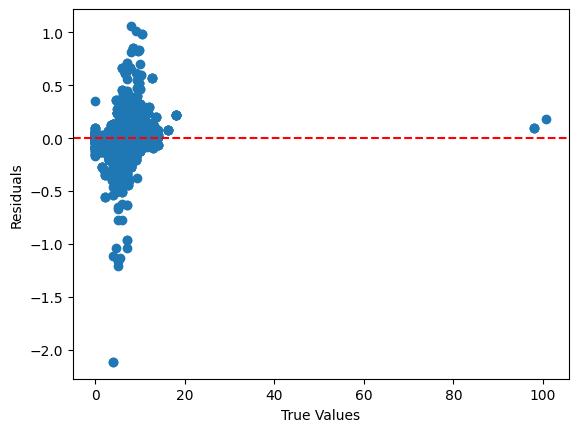

In [33]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

Final Model Training

Since the model is performing well, now proceed with training the final model on the entire training set and making predictions on the test set.

In [32]:
# encoding dim 7, no hidden layers

# combine new features with original scaled data
X_new = pd.concat([X_scaled, X_embeddings_pd0], axis=1)
X_new.head()

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Train the final model on the entire training set
final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set - Mean Squared Error (MSE): {mse_test}")
print(f"Test Set - R² Score: {r2_test}")


Test Set - Mean Squared Error (MSE): 0.007662199094636744
Test Set - R² Score: 0.9991292203992438


Final Model Performance:

Mean Squared Error (MSE): 0.0077 — This low value indicates that the model’s predictions are very close to the actual values of dissolved oxygen. This is an improvement of the previous model which had an MSE of 0.013.

R² Score: 0.9991 — This very high R² score means that the model explains 99.91% of the variance in the test data, confirming that the model generalizes very well to unseen data. This is a slight improvement from the previous model which had an R² Score of 0.9985.

Conclusion:

The model performs exceptionally well, both during cross-validation and on the test set. There are no signs of overfitting, and the model can accurately predict dissolved oxygen levels based on the provided features.





Feature Importance:

Visualize the feature importance to understand which features contribute most to the predictions.

<Figure size 1000x600 with 0 Axes>

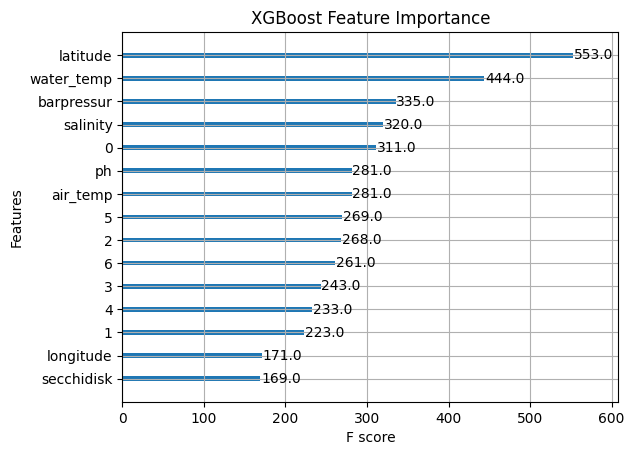

<Figure size 640x480 with 0 Axes>

In [38]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot the feature importance
plt.figure(figsize=(10, 6))
plot_importance(final_model)
plt.title('XGBoost Feature Importance')
plt.show()

From the results of the XGBoost, it appears that two of the embeddings ("0" and "1") performed better than 2 of the worst performing initial features (ph and seccidisk), and that the third embedding ("2") performed better than seccidisk. This suggests that the autoencoder embeddings provided additional information that the model was able to utilize to make predictions.

SHAP Analysis for Feature Impact

Compute SHAP values for the test set and visualize how features contribute to the prediction.

 98%|===================| 8424/8586 [00:37<00:00]        

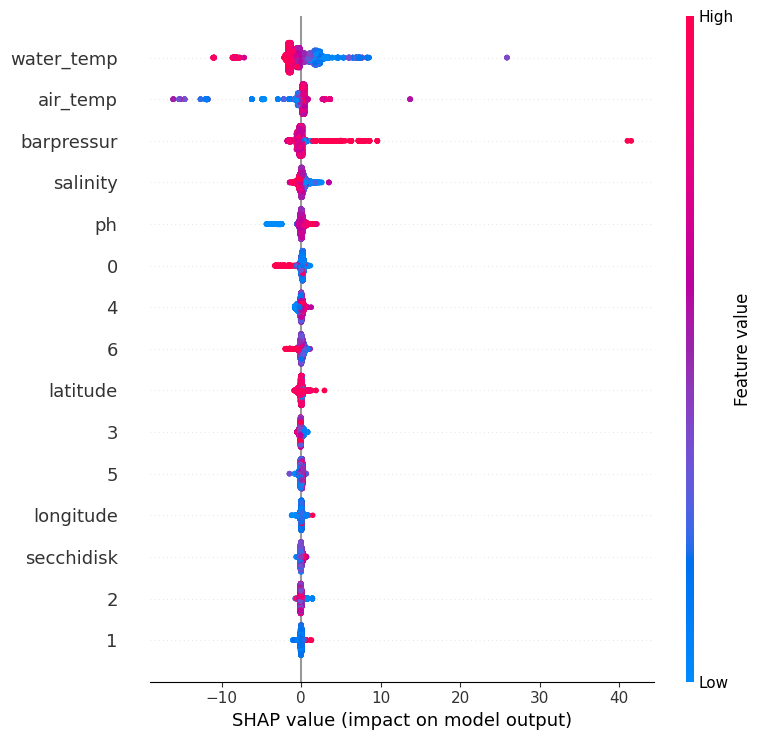

<Figure size 640x480 with 0 Axes>

In [37]:
# Create a SHAP explainer object
explainer = shap.Explainer(final_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot summary of SHAP values (feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_new.columns)


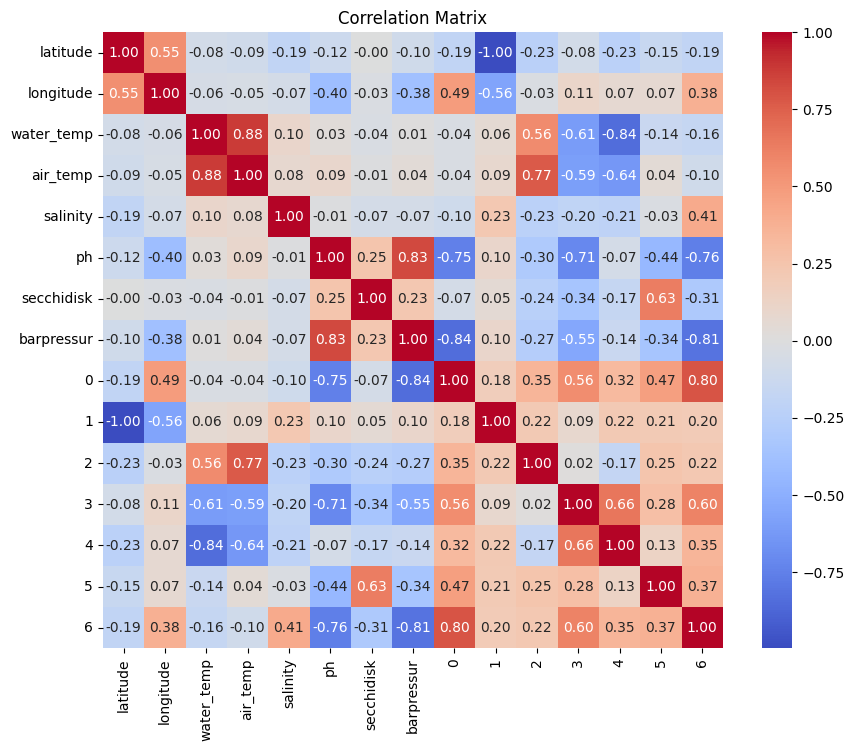

<Figure size 640x480 with 0 Axes>

In [36]:
# Compute the correlation matrix for numeric columns
corr_matrix = X_new.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Future work: Exploring the use of a denoising autoencoder

Note: all work below was determined to be outside the scope of this project and left intentionally as future work.

## Import the data

In [ ]:
# Import the data
data = pd.read_csv(file_path)

## Drop rows missing O2 and convert to numeric types

In [ ]:
# Drop rows with missing target variable 'dissoxygen'
data = data.dropna(subset=['dissoxygen'])

# Remove the first row (units) and reset the index
data = data.iloc[1:].reset_index(drop=True)

# Convert relevant columns to numeric types
numeric_columns = ['latitude', 'longitude', 'water_temp', 'air_temp', 'salinity', 'ph', 'dissoxygen', 'secchidisk', 'barpressur']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

## Standardize the data

In [ ]:
X = data[['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']]
y = data['dissoxygen']

columns_to_standardize = ['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=columns_to_standardize, index=X.index)

In [ ]:
print(y.shape)

## Create Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
print(y_train.shape)

## Impute missing data

In [ ]:
# Apply KNN Imputation

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the numeric columns
X_train[columns_to_standardize] = knn_imputer.fit_transform(X_train[columns_to_standardize])

# Display the dataset information after imputation
print(X_train.info())

# Display the first few rows of the imputed dataset
print(X_train.head())

# Plot histograms for each numeric feature to visualize distributions
X_train[columns_to_standardize].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

## Define the noise function

In [ ]:
# Function to add noise to the data
def add_noise(data, noise_factor=0.2):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noisy_data = np.clip(noisy_data, 0., 1.)  # Ensure data is within valid range (0, 1)
    return noisy_data

## Define the autoencoder

In [ ]:
# Function to create the denoising autoencoder model
def create_denoising_autoencoder(encoding_dim=3, input_dim=8, hidden_layers=[8, 4, 3]):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)

    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu')(encoded)

    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Denoising Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, input_layer, encoded

## Add noise and run denoising autoencoder

In [54]:
# Add noise to the data
X_noisy = add_noise(X_train, noise_factor=0.2)

# Create the denoising autoencoder model
encoding_dim = 3  # Chosen from previous experiments
hidden_layers = [8, 4, 3]  # Architecture configuration
autoencoder, input_layer, encoded = create_denoising_autoencoder(encoding_dim=encoding_dim, input_dim=X_train.shape[1], hidden_layers=hidden_layers)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best validation loss

# Train on the noisy data, but validate against the original clean data
autoencoder.fit(X_noisy, X_train, 
                epochs=500, 
                batch_size=16, 
                validation_split=0.2, 
                verbose=1, 
                callbacks=[early_stopping])  # Include early stopping in the training process

# Extract the encoder part of the autoencoder to get the latent space representation
encoder = Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder.predict(X_train)


Epoch 1/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1280 - val_loss: 1.0111
Epoch 2/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9005 - val_loss: 0.9806
Epoch 3/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9100 - val_loss: 0.9722
Epoch 4/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9269 - val_loss: 0.9700
Epoch 5/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9108 - val_loss: 0.9693
Epoch 6/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9123 - val_loss: 0.9686
Epoch 7/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8914 - val_loss: 0.9682
Epoch 8/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9135 - val_loss: 0.9646
Epoch 9/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8670 - val_loss: 0.9433
Epoch 10/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8824 - val_loss: 0.9379
Epoch 11/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8850 - val_loss: 0.9367
Epoch 12/500
1718/1

In [ ]:
X_encoded_df = pd.DataFrame(X_encoded)
X_encoded_df.info()

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34343 entries, 32456 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    34343 non-null  float64
 1   longitude   34343 non-null  float64
 2   water_temp  34343 non-null  float64
 3   air_temp    34343 non-null  float64
 4   salinity    34343 non-null  float64
 5   ph          34343 non-null  float64
 6   secchidisk  34343 non-null  float64
 7   barpressur  34343 non-null  float64
dtypes: float64(8)
memory usage: 3.4 MB


In [56]:
y_train_df = pd.DataFrame(y_train)
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34343 entries, 32456 to 15795
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dissoxygen  34343 non-null  float64
dtypes: float64(1)
memory usage: 536.6 KB


In [25]:
print(X_encoded_df.shape)
print(X_train.shape)

(34343, 3)
(34343, 8)


In [40]:
print(X_train.index.equals(X_encoded_df.index))

False


In [57]:
# Check if they have the same number of rows
if X_train.shape[0] == X_encoded_df.shape[0]:
    # Ensure indices are aligned
    if X_train.index.equals(X_encoded_df.index):
        X_new = pd.concat([X_train, X_encoded_df], axis=1)
    else:
        # Align by resetting the index or sorting
        X_train = X_train.reset_index(drop=True)
        X_encoded_df = X_encoded_df.reset_index(drop=True)
        X_new = pd.concat([X_train, X_encoded_df], axis=1)
else:
    raise ValueError("X_train and X_encoded_df must have the same number of rows.")

print(X_new.shape)

(34343, 11)


In [58]:
# Encode the Test Data
X_encoded_test = encoder.predict(X_test)

# Convert the encoded test data to a DataFrame
X_encoded_test_df = pd.DataFrame(X_encoded_test, index=X_test.index)

# Combine the encoded features with the original test data

# Check if they have the same number of rows
if X_test.shape[0] == X_encoded_test_df.shape[0]:
    # Ensure indices are aligned
    if X_test.index.equals(X_encoded_test_df.index):
        X_test_new = pd.concat([X_test, X_encoded_test_df], axis=1)
    else:
        # Align by resetting the index or sorting
        X_test = X_test.reset_index(drop=True)
        X_encoded_test_df = X_encoded_test_df.reset_index(drop=True)
        X_test_new = pd.concat([X_test, X_encoded_test_df], axis=1)
else:
    raise ValueError("X_test and X_encoded_test_df must have the same number of rows.")

print(X_test_new.shape)

# Ensure the new test set has the same columns as the training set
print(X_test_new.shape)  # Should match X_new.shape
print(X_test_new.columns)  # Should match X_new.columns

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(8586, 11)
(8586, 11)
Index([  'latitude',  'longitude', 'water_temp',   'air_temp',   'salinity',
               'ph', 'secchidisk', 'barpressur',            0,            1,
                  2],
      dtype='object')


In [59]:
# Train the final model on the entire training set
denoising_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
denoising_model.fit(X_new, y_train_df)

# Make predictions on the test set
y_pred_test = denoising_model.predict(X_test_new)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set - Mean Squared Error (MSE): {mse_test}")
print(f"Test Set - R² Score: {r2_test}")

Test Set - Mean Squared Error (MSE): 11.183575381887735
Test Set - R² Score: -0.2757825045118305


In [22]:
print(X_new.shape)
print(y_train_df.shape)

(41206, 11)
(34343, 1)


<Figure size 1000x600 with 0 Axes>

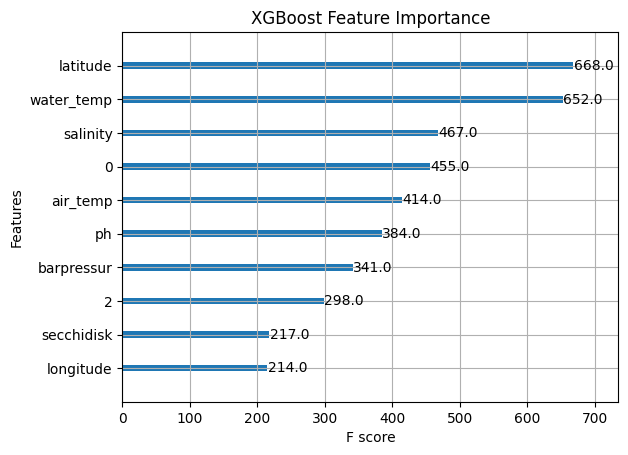

In [60]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plot_importance(denoising_model)
plt.title('XGBoost Feature Importance')
plt.show()

In [61]:
# Create a SHAP explainer object
explainer = shap.Explainer(denoising_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot summary of SHAP values (feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_new.columns)

 98%|===================| 8456/8586 [00:32<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 9.692599, while the model output was 7.066539. If this difference is acceptable you can set check_additivity=False to disable this check.

# Future work: Denoise with only 7-dim bottleneck and no hidden layers

In [2]:
data = pd.read_csv(file_path)


Columns (0,1,3,6,7,8,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Drop rows with missing target variable 'dissoxygen'
data = data.dropna(subset=['dissoxygen'])

# Remove the first row (units) and reset the index
data = data.iloc[1:].reset_index(drop=True)

# Convert relevant columns to numeric types
numeric_columns = ['latitude', 'longitude', 'water_temp', 'air_temp', 'salinity', 'ph', 'dissoxygen', 'secchidisk', 'barpressur']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [4]:
X = data[['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']]
y = data['dissoxygen']

columns_to_standardize = ['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=columns_to_standardize, index=X.index)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 34343 entries, 32456 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    34343 non-null  float64
 1   longitude   34343 non-null  float64
 2   water_temp  34343 non-null  float64
 3   air_temp    34343 non-null  float64
 4   salinity    34343 non-null  float64
 5   ph          34343 non-null  float64
 6   secchidisk  34343 non-null  float64
 7   barpressur  34343 non-null  float64
dtypes: float64(8)
memory usage: 2.4 MB
None
       latitude  longitude  water_temp  air_temp  salinity        ph  \
32456  0.260229   0.070542   -0.820025 -1.121038 -1.172217  0.313703   
36107  0.167581  -0.367401    0.544711  0.246336 -0.233201 -0.340597   
10342  0.154502  -0.025124   -1.333636 -1.171681  0.692401 -0.039619   
28361  0.167581  -0.367401   -0.115645 -0.563960  0.169235  0.352962   
34     0.968357   2.159144   -1.186890 -2.766951  1.108251 -4.920703   

     

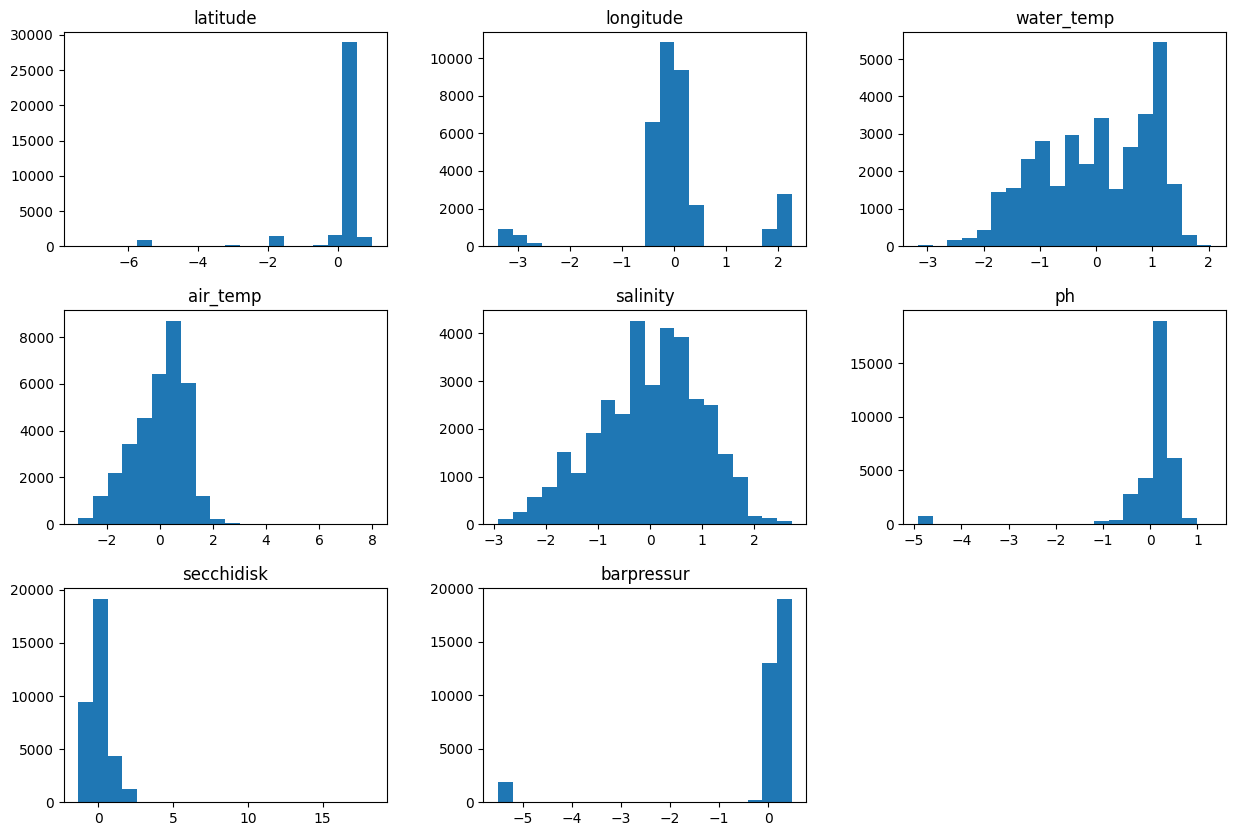

In [6]:
# Apply KNN Imputation

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the numeric columns
X_train[columns_to_standardize] = knn_imputer.fit_transform(X_train[columns_to_standardize])

# Display the dataset information after imputation
print(X_train.info())

# Display the first few rows of the imputed dataset
print(X_train.head())

# Plot histograms for each numeric feature to visualize distributions
X_train[columns_to_standardize].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

In [7]:
# Function to add noise to the data
def add_noise(data, noise_factor=0.2):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noisy_data = np.clip(noisy_data, 0., 1.)  # Ensure data is within valid range (0, 1)
    return noisy_data

In [13]:
def create_simple_denoising_autoencoder(encoding_dim, input_dim):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoding layer
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    
    # Decoding layer
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    # Compile the model
    autoencoder.compile(optimizer=Adam(), loss='mse')
    
    return autoencoder, input_layer, encoded

# Add noise to the data
X_noisy = add_noise(X_train, noise_factor=0.2)

# Set encoding dimension
encoding_dim = 7  # Number of features in the encoded representation

# Create the simplified autoencoder model
autoencoder, input_layer, encoded = create_simple_denoising_autoencoder(encoding_dim=encoding_dim, input_dim=X_train.shape[1])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train on the noisy data, but validate against the original clean data
autoencoder.fit(X_noisy, X_train, 
                epochs=500, 
                batch_size=16, 
                validation_split=0.2, 
                verbose=1, 
                callbacks=[early_stopping])

# Extract the encoder part of the autoencoder to get the latent space representation
encoder = Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder.predict(X_train)


Epoch 1/500


I0000 00:00:1725321668.006092     210 service.cc:145] XLA service 0x7e59900126a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725321668.006143     210 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725321668.006149     210 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 119/1718 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0791

I0000 00:00:1725321669.195396     210 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1718/1718 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0977 - val_loss: 0.9407
Epoch 2/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8249 - val_loss: 0.8934
Epoch 3/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8181 - val_loss: 0.8876
Epoch 4/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8144 - val_loss: 0.8860
Epoch 5/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8099 - val_loss: 0.8848
Epoch 6/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8242 - val_loss: 0.8841
Epoch 7/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8077 - val_loss: 0.8837
Epoch 8/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7992 - val_loss: 0.8836
Epoch 9/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8046 - val_loss: 0.8834
Epoch 10/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8165 - val_loss: 0.8834
Epoch 11/500
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8131 - val_loss: 0.8833
Epoch 12/500
1718/1718 ━━━━━━━━

In [14]:
X_encoded_df = pd.DataFrame(X_encoded)
X_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34343 entries, 0 to 34342
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       34343 non-null  float32
 1   1       34343 non-null  float32
 2   2       34343 non-null  float32
 3   3       34343 non-null  float32
 4   4       34343 non-null  float32
 5   5       34343 non-null  float32
 6   6       34343 non-null  float32
dtypes: float32(7)
memory usage: 939.2 KB


In [15]:
y_train_df = pd.DataFrame(y_train)
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34343 entries, 32456 to 15795
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dissoxygen  34343 non-null  float64
dtypes: float64(1)
memory usage: 536.6 KB


In [16]:
# Check if they have the same number of rows
if X_train.shape[0] == X_encoded_df.shape[0]:
    # Ensure indices are aligned
    if X_train.index.equals(X_encoded_df.index):
        X_new = pd.concat([X_train, X_encoded_df], axis=1)
    else:
        # Align by resetting the index or sorting
        X_train = X_train.reset_index(drop=True)
        X_encoded_df = X_encoded_df.reset_index(drop=True)
        X_new = pd.concat([X_train, X_encoded_df], axis=1)
else:
    raise ValueError("X_train and X_encoded_df must have the same number of rows.")

print(X_new.shape)

(34343, 15)


In [17]:
# Encode the Test Data
X_encoded_test = encoder.predict(X_test)

# Convert the encoded test data to a DataFrame
X_encoded_test_df = pd.DataFrame(X_encoded_test, index=X_test.index)

# Combine the encoded features with the original test data

# Check if they have the same number of rows
if X_test.shape[0] == X_encoded_test_df.shape[0]:
    # Ensure indices are aligned
    if X_test.index.equals(X_encoded_test_df.index):
        X_test_new = pd.concat([X_test, X_encoded_test_df], axis=1)
    else:
        # Align by resetting the index or sorting
        X_test = X_test.reset_index(drop=True)
        X_encoded_test_df = X_encoded_test_df.reset_index(drop=True)
        X_test_new = pd.concat([X_test, X_encoded_test_df], axis=1)
else:
    raise ValueError("X_test and X_encoded_test_df must have the same number of rows.")

print(X_test_new.shape)

# Ensure the new test set has the same columns as the training set
print(X_test_new.shape)  # Should match X_new.shape
print(X_test_new.columns)  # Should match X_new.columns

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(8586, 15)
(8586, 15)
Index([  'latitude',  'longitude', 'water_temp',   'air_temp',   'salinity',
               'ph', 'secchidisk', 'barpressur',            0,            1,
                  2,            3,            4,            5,            6],
      dtype='object')


In [18]:
# Train the final model on the entire training set
denoising_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
denoising_model.fit(X_new, y_train_df)

# Make predictions on the test set
y_pred_test = denoising_model.predict(X_test_new)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set - Mean Squared Error (MSE): {mse_test}")
print(f"Test Set - R² Score: {r2_test}")

Test Set - Mean Squared Error (MSE): 10.70428755372374
Test Set - R² Score: -0.2211070536906743


<Figure size 1000x600 with 0 Axes>

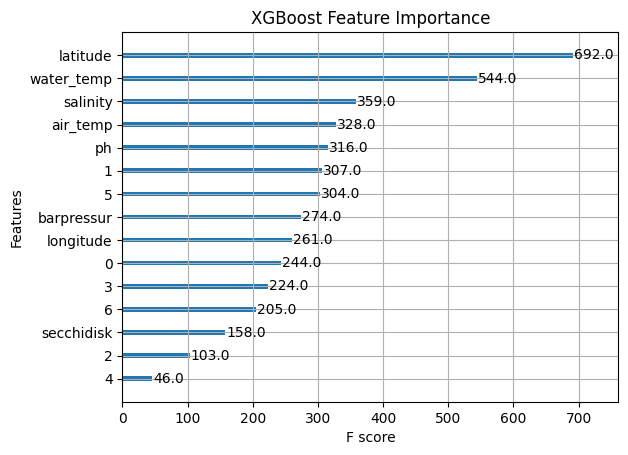

In [19]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plot_importance(denoising_model)
plt.title('XGBoost Feature Importance')
plt.show()

 98%|===================| 8432/8586 [00:46<00:00]        

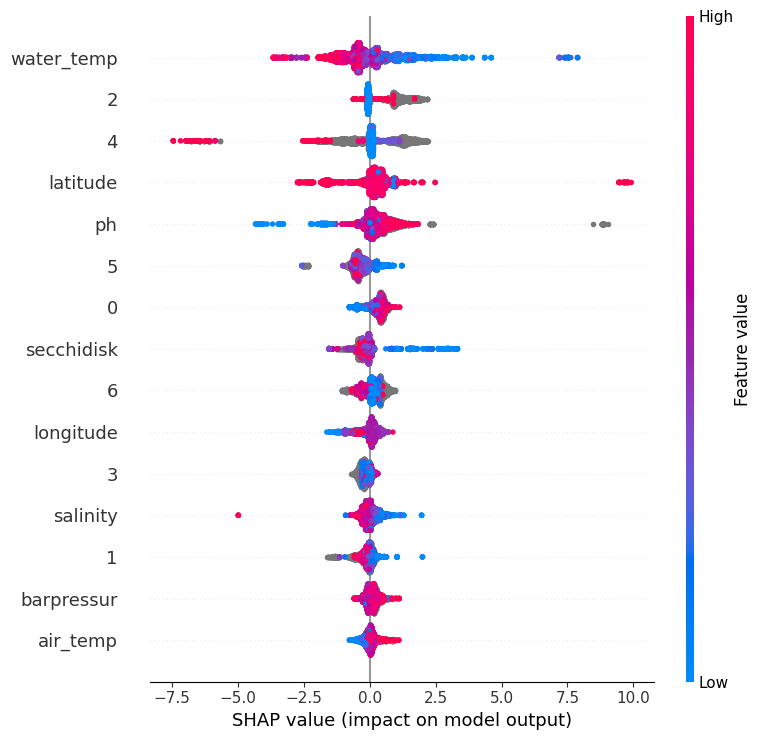

In [20]:
# Create a SHAP explainer object
explainer = shap.Explainer(denoising_model, X_new)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_new)

# Plot summary of SHAP values (feature importance)
shap.summary_plot(shap_values, X_test_new, feature_names=X_new.columns)

# Future work: Avoid data leakage

The original model was trained on imputed data which was completed prior to splitting the data into testing and training sets. To avoid data leakage, we can implement test/train split prior to imputing the missing data. 

In [21]:
data = pd.read_csv(file_path)
# Drop rows with missing target variable 'dissoxygen'
data = data.dropna(subset=['dissoxygen'])

# Remove the first row (units) and reset the index
data = data.iloc[1:].reset_index(drop=True)

# Convert relevant columns to numeric types
numeric_columns = ['latitude', 'longitude', 'water_temp', 'air_temp', 'salinity', 'ph', 'dissoxygen', 'secchidisk', 'barpressur']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')


X = data[['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']]
y = data['dissoxygen']

columns_to_standardize = ['latitude','longitude','water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=columns_to_standardize, index=X.index)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Columns (0,1,3,6,7,8,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
Index: 34343 entries, 32456 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    34343 non-null  float64
 1   longitude   34343 non-null  float64
 2   water_temp  34343 non-null  float64
 3   air_temp    34343 non-null  float64
 4   salinity    34343 non-null  float64
 5   ph          34343 non-null  float64
 6   secchidisk  34343 non-null  float64
 7   barpressur  34343 non-null  float64
dtypes: float64(8)
memory usage: 2.4 MB
None
       latitude  longitude  water_temp  air_temp  salinity        ph  \
32456  0.260229   0.070542   -0.820025 -1.121038 -1.172217  0.313703   
36107  0.167581  -0.367401    0.544711  0.246336 -0.233201 -0.340597   
10342  0.154502  -0.025124   -1.333636 -1.171681  0.692401 -0.039619   
28361  0.167581  -0.367401   -0.115645 -0.563960  0.169235  0.352962   
34     0.968357   2.159144   -1.186890 -2.766951  1.108251 -4.920703   

     

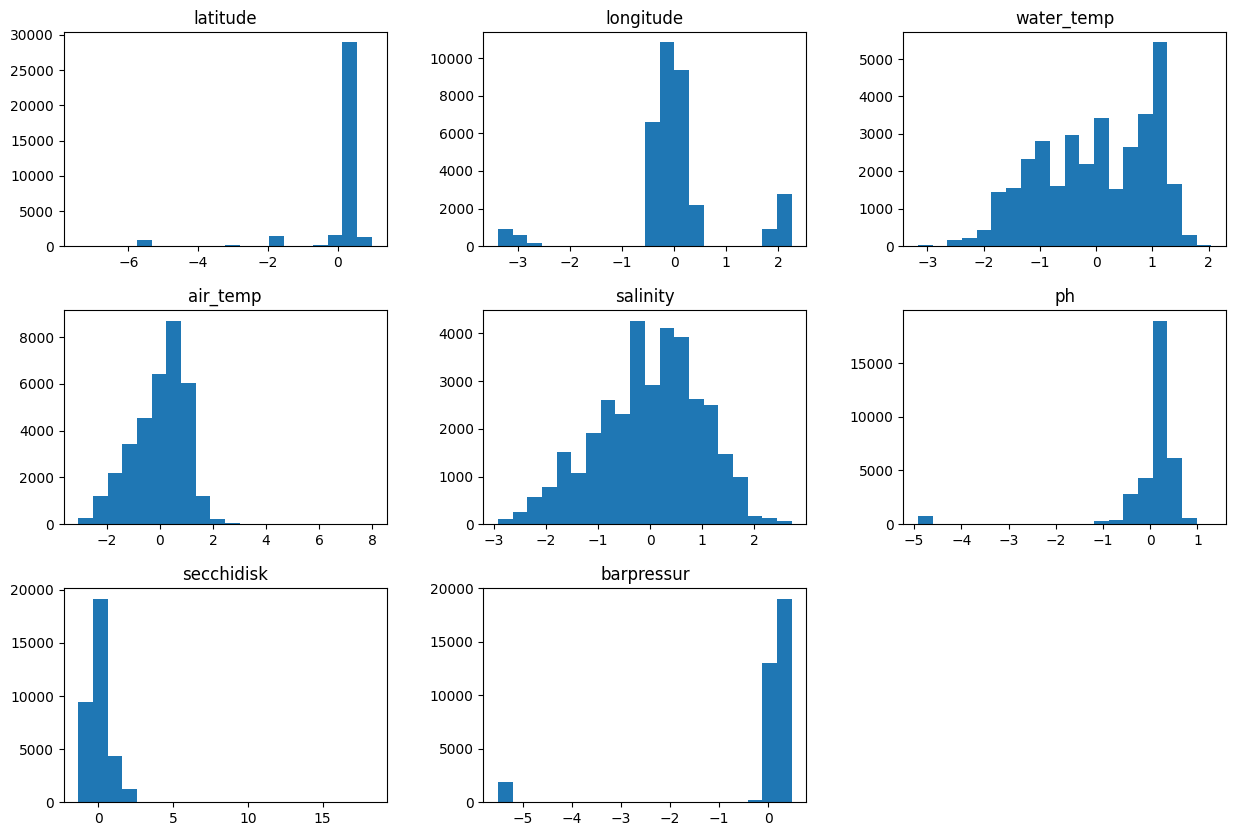

In [22]:
# Apply KNN Imputation

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the numeric columns
X_train[columns_to_standardize] = knn_imputer.fit_transform(X_train[columns_to_standardize])

# Display the dataset information after imputation
print(X_train.info())

# Display the first few rows of the imputed dataset
print(X_train.head())

# Plot histograms for each numeric feature to visualize distributions
X_train[columns_to_standardize].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

In [24]:
epochs = 50
best_batch_size = 16
best_encoding_dim = 7

In [25]:
# Function to create the autoencoder model

def create_autoencoder0(encoding_dim=3, input_dim=6):
    input_layer0 = Input(shape=(input_dim,))

    # Encoder
    encoded0 = Dense(encoding_dim, activation='relu')(input_layer0)

    # Decoder
    decoded0 = Dense(input_dim, activation='sigmoid')(encoded0)

    # Autoencoder model
    autoencoder0 = Model(inputs=input_layer0, outputs=decoded0)
    autoencoder0.compile(optimizer='adam', loss='mse')

    return autoencoder0, input_layer0, encoded0

# Create the autoencoder model with the best configuration
autoencoder0, input_layer0, encoded0 = create_autoencoder0(encoding_dim=best_encoding_dim, input_dim=X_train.shape[1])

# Train the autoencoder on the full dataset
autoencoder0.fit(X_train, X_train, epochs=epochs, batch_size=best_batch_size, verbose=0) # fit AND test on same original dataset

# Create a separate model for just the encoder to extract embeddings
encoder0 = Model(inputs=input_layer0, outputs=encoded0)

# Generate embeddings
X_embeddings0 = encoder0.predict(X_train)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [26]:
# Convert embeddings and y_train to pandas data frames

X_encoded_df = pd.DataFrame(X_embeddings0, index=X_train.index)
print(X_encoded_df.shape)

y_train_df = pd.DataFrame(y_train)
print(y_train_df.shape)

(34343, 7)
(34343, 1)


In [27]:
# Check if they have the same number of rows
if X_train.shape[0] == X_encoded_df.shape[0]:
    # Ensure indices are aligned
    if X_train.index.equals(X_encoded_df.index):
        X_new = pd.concat([X_train, X_encoded_df], axis=1)
    else:
        # Align by resetting the index or sorting
        X_train = X_train.reset_index(drop=True)
        X_encoded_df = X_encoded_df.reset_index(drop=True)
        X_new = pd.concat([X_train, X_encoded_df], axis=1)
else:
    raise ValueError("X_train and X_encoded_df must have the same number of rows.")

print(X_new.shape)

(34343, 15)


In [28]:
# Encode the Test Data
X_encoded_test = encoder.predict(X_test)

# Convert the encoded test data to a DataFrame
X_encoded_test_df = pd.DataFrame(X_encoded_test, index=X_test.index)

# Combine the encoded features with the original test data

# Check if they have the same number of rows
if X_test.shape[0] == X_encoded_test_df.shape[0]:
    # Ensure indices are aligned
    if X_test.index.equals(X_encoded_test_df.index):
        X_test_new = pd.concat([X_test, X_encoded_test_df], axis=1)
    else:
        # Align by resetting the index or sorting
        X_test = X_test.reset_index(drop=True)
        X_encoded_test_df = X_encoded_test_df.reset_index(drop=True)
        X_test_new = pd.concat([X_test, X_encoded_test_df], axis=1)
else:
    raise ValueError("X_test and X_encoded_test_df must have the same number of rows.")

print(X_test_new.shape)

# Ensure the new test set has the same columns as the training set
print(X_test_new.shape)  # Should match X_new.shape
print(X_test_new.columns)  # Should match X_new.columns

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(8586, 15)
(8586, 15)
Index([  'latitude',  'longitude', 'water_temp',   'air_temp',   'salinity',
               'ph', 'secchidisk', 'barpressur',            0,            1,
                  2,            3,            4,            5,            6],
      dtype='object')


In [29]:
# Train the final model on the entire training set
denoising_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
denoising_model.fit(X_new, y_train_df)

# Make predictions on the test set
y_pred_test = denoising_model.predict(X_test_new)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set - Mean Squared Error (MSE): {mse_test}")
print(f"Test Set - R² Score: {r2_test}")

Test Set - Mean Squared Error (MSE): 26.448177393812692
Test Set - R² Score: -2.017114012563308


This model was unable to make accurate predictions on the testing set.

<Figure size 1000x600 with 0 Axes>

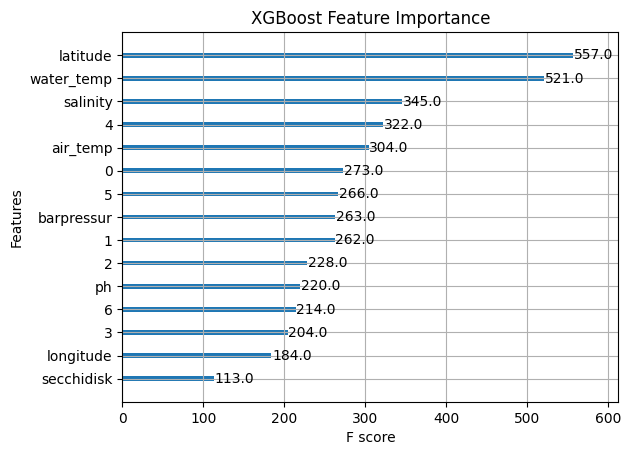

In [30]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plot_importance(denoising_model)
plt.title('XGBoost Feature Importance')
plt.show()

 99%|===================| 8492/8586 [00:44<00:00]        

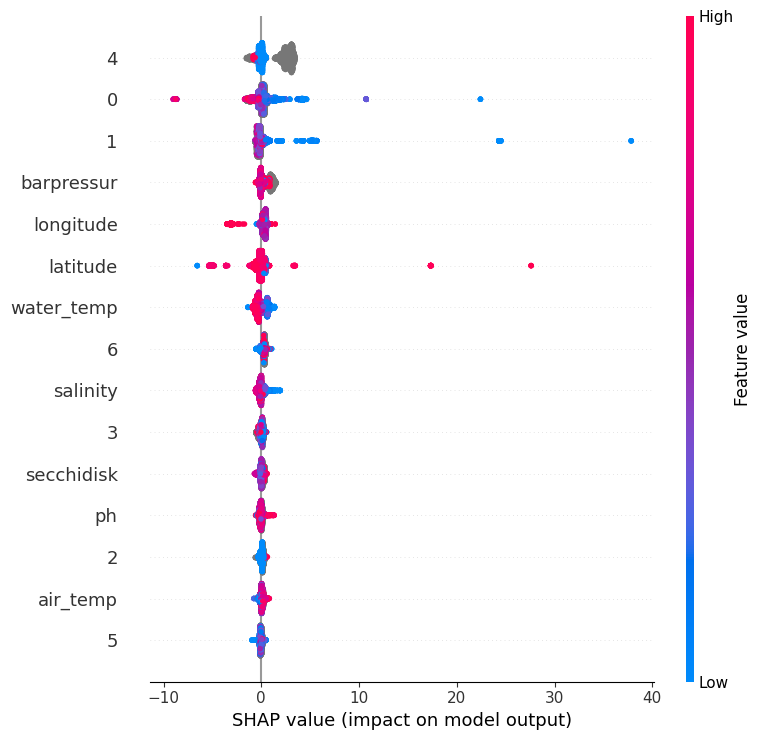

In [31]:
# Create a SHAP explainer object
explainer = shap.Explainer(denoising_model, X_new)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_new)

# Plot summary of SHAP values (feature importance)
shap.summary_plot(shap_values, X_test_new, feature_names=X_new.columns)